In [2]:
import os
import sys
import numpy as np
import glob
import pandas as pd
import shutil
import gzip
import nibabel
import scipy.io
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome import vec_to_sym_matrix
import scipy.stats
import utils
import math

# ASD and TD analysis

In [3]:
dfnc = h5py.File('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/CPAC_NFNG__dfnc.mat')
dfnc.keys()

<ipython-input-3-8f60d44c309b>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  dfnc = h5py.File('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/CPAC_NFNG__dfnc.mat')


<KeysViewHDF5 ['#refs#', 'dfncInfo']>

In [4]:
dfnc['dfncInfo']['postprocess'].keys()

<KeysViewHDF5 ['dmethod', 'estimate_clusters', 'ica', 'kmeans_max_iter', 'kmeans_num_replicates', 'kmeans_start', 'meta_method', 'num_clusters', 'num_tests_est_clusters', 'regressCovFile']>

In [5]:
dfnc['dfncInfo']['postprocess']['kmeans_num_replicates'].value

<ipython-input-5-1d0418e493bd>:1: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  dfnc['dfncInfo']['postprocess']['kmeans_num_replicates'].value


array([[100.]])

In [6]:
asd_idx = np.array(range(170), dtype = 'uint32')
td_idx = np.array(range(170,365), dtype = 'uint32')
groups = {'ASD' : asd_idx, 'TD' : td_idx}

In [7]:
# print('ASD indices : ', asd_idx)
# print('TD indices : ', td_idx)

## Silhouette and Elbow scores

In [29]:
pp = h5py.File('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/CPAC_NFNG__dfnc_post_process_estimateK.mat')
pp.keys()

<ipython-input-29-ae39aaf9a910>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  pp = h5py.File('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/CPAC_NFNG__dfnc_post_process_estimateK.mat')


<KeysViewHDF5 ['#refs#', 'FNCamp', 'FNCcm', 'clusterInfo', 'cluster_estimate_results', 'meta_states_info', 'tvdfncInfo']>

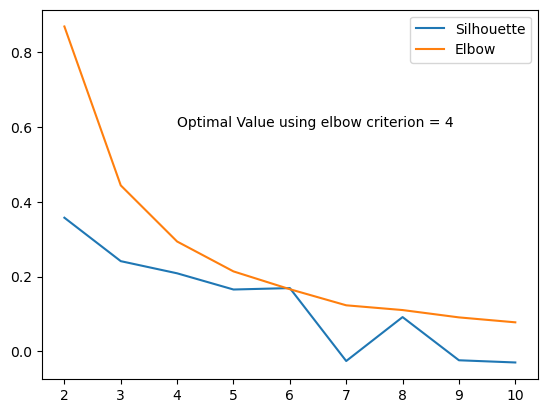

In [9]:
# These values are directly copied from above mat file using matlab 
silhoutte_scores = [0.3574, 0.2413, 0.2088, 0.1655, 0.1693, -0.0256, 0.0918,	-0.0236, -0.0295] # 
elbow_scores = [0.8685,	0.4438,	0.2938,	0.2139,	0.1663,	0.1233,	0.1106,	0.0910,	0.0778]

plt.plot(range(2,11), silhoutte_scores, label = 'Silhouette')
plt.plot(range(2,11), elbow_scores, label = 'Elbow')
plt.text(4, 0.6, 'Optimal Value using elbow criterion = 4')
plt.legend()
plt.show()

## Distribution of Windows per state per group 

In [10]:
pp = h5py.File('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/CPAC_NFNG__dfnc_post_process.mat')
pp.keys()

<ipython-input-10-6af6c812f6c8>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  pp = h5py.File('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/CPAC_NFNG__dfnc_post_process.mat')


<KeysViewHDF5 ['#refs#', 'FNCamp', 'FNCcm', 'clusterInfo', 'meta_states_info', 'tvdfncInfo']>

In [11]:
states = pp['clusterInfo']['states']
states = np.squeeze(states, 1)
print('State array shape : ', states.shape)                # (n_windows, n_subjects)
asd_states = states[:, asd_idx]
td_states = states[:, td_idx]
print('Number of windows')
print('ASD : ', np.unique(asd_states, return_counts=True))
print('_' * 10)
print('TD : ', np.unique(td_states, return_counts=True))

State array shape :  (130, 365)
Number of windows
ASD :  (array([1., 2., 3., 4.]), array([15255,  1167,  1187,  4491]))
__________
TD :  (array([1., 2., 3., 4.]), array([17729,  2140,  1143,  4338]))


## Two Sample-T test

In [12]:
cs = scipy.io.loadmat('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/Stats_K4/CPAC_NFNG__dfnc_cluster_stats.mat')
print('Cluster stats using GIFT mat file keys : ', cs.keys())
dfnc_corrs = cs['dfnc_corrs']
dfnc_corrs = np.squeeze(dfnc_corrs)
dfnc_corrs.shape

Cluster stats using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'thresholdWindows', 'dfnc_corrs', 'state_vector_stats', 'nuisance_cov_file'])


(365, 1378, 4)

In [13]:
dfnc_dict = utils.get_groups_dfnc(dfnc_corrs, groups, n_states = 4, mode = 'all')
print('Keys in dfnc_dict : ', list(dfnc_dict.keys()))
print('Keys in dfnc_dict[0] : ', list(dfnc_dict[0].keys()))
print('Shape of dfnc_dict[0]["ASD"] : ',dfnc_dict[0]["ASD"].shape)
print('Shape of dfnc_dict[0]["TD"] : ',dfnc_dict[0]["TD"].shape)

State :  1
Group : ASD and DFNC shape : (139, 1378)
Group : TD and DFNC shape : (156, 1378)
------------------------------------------------
State :  2
Group : ASD and DFNC shape : (17, 1378)
Group : TD and DFNC shape : (26, 1378)
------------------------------------------------
State :  3
Group : ASD and DFNC shape : (16, 1378)
Group : TD and DFNC shape : (15, 1378)
------------------------------------------------
State :  4
Group : ASD and DFNC shape : (59, 1378)
Group : TD and DFNC shape : (65, 1378)
------------------------------------------------
Keys in dfnc_dict :  [0, 1, 2, 3]
Keys in dfnc_dict[0] :  ['ASD', 'TD']
Shape of dfnc_dict[0]["ASD"] :  (139, 1378)
Shape of dfnc_dict[0]["TD"] :  (156, 1378)


**The above values were cross-checked with GIFT results**

In [14]:
t1, p1 = utils.two_sample_ttest(dfnc_dict, state = 0)
t2, p2 = utils.two_sample_ttest(dfnc_dict, state = 1)
t3, p3 = utils.two_sample_ttest(dfnc_dict, state = 2)
t4, p4 = utils.two_sample_ttest(dfnc_dict, state = 3)
print('T-Values shape : ', t1.shape)
print('P-Values shape : ', p1.shape)

T-Values shape :  (1378,)
P-Values shape :  (1378,)


Concatenated p-values shape :  (4, 1378)


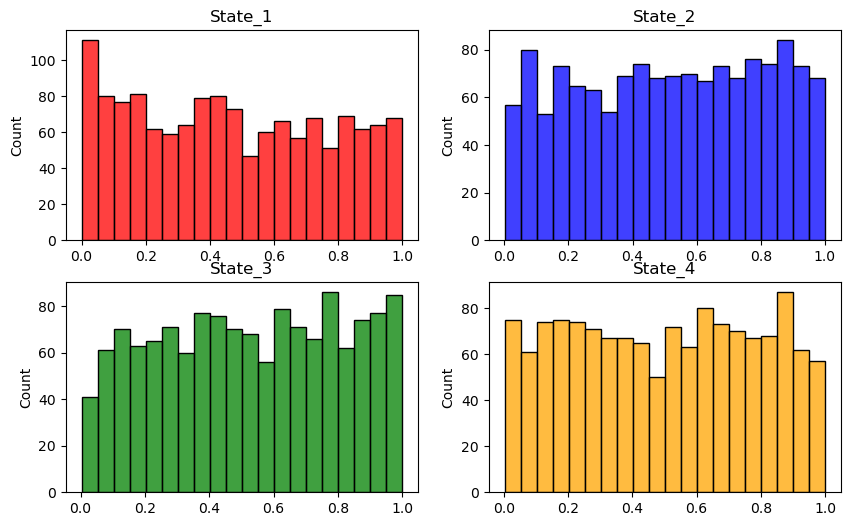

In [15]:
p = np.vstack([p1, p2, p3, p4])
print('Concatenated p-values shape : ', p.shape)    # n_states, 1378
labels = ['State_1', 'State_2', 'State_3', 'State_4']
utils.hist_plot(p, labels)

In [16]:
print('Number of connectivities with p values less than 0.05', (p1 < 0.05).sum())
print('Number of connectivities with p values less than 0.05', (p2 < 0.05).sum())
print('Number of connectivities with p values less than 0.05', (p3 < 0.05).sum())
print('Number of connectivities with p values less than 0.05', (p4 < 0.05).sum())

Number of connectivities with p values less than 0.05 109
Number of connectivities with p values less than 0.05 56
Number of connectivities with p values less than 0.05 38
Number of connectivities with p values less than 0.05 72


**Checking the above p-values with GIFT generated p-values**

In [17]:
tt = scipy.io.loadmat('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/Stats_K4/CPAC_NFNG__dfnc_two_sample_ttest_results.mat')
print('Two sample ttest using GIFT mat file keys : ', tt.keys())

p_state1_gift = np.array(tt['p_u'][0][0][0], dtype = 'float64')
p_state2_gift = np.array(tt['p_u'][0][1][0], dtype = 'float64')
p_state3_gift = np.array(tt['p_u'][0][2][0], dtype = 'float64')
p_state4_gift = np.array(tt['p_u'][0][3][0], dtype = 'float64')

print('Shape of p_state1_gift : ', p_state1_gift.shape)
print('Shape of p_state2_gift : ', p_state2_gift.shape)
print('Shape of p_state3_gift : ', p_state3_gift.shape)
print('Shape of p_state4_gift : ', p_state4_gift.shape)

Two sample ttest using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'groupNames', 'groupVals', 't_u', 'p_u', 'stats_u', 'N', 'mean_u', 'subject_indices'])
Shape of p_state1_gift :  (1378,)
Shape of p_state2_gift :  (1378,)
Shape of p_state3_gift :  (1378,)
Shape of p_state4_gift :  (1378,)


In [18]:
print(np.array_equal(np.round(p1, 4), np.round(p_state1_gift, 4)))
print(np.array_equal(np.round(p2, 4), np.round(p_state2_gift, 4)))
print(np.array_equal(np.round(p3, 4), np.round(p_state3_gift, 4)))
print(np.array_equal(np.round(p4, 4), np.round(p_state4_gift, 4)))

True
True
True
True


In [19]:
test={0:1,1:2,3:5, 4:7}
list(test)

[0, 1, 3, 4]

## POC PLot of ASD and TD

States array shape :  (130, 365)
States values :  [1 2 3 4]
['ASD', 'TD']
p-values of 4 states :  {0: 0.35666513907240716, 1: 0.38938211727172567, 2: 0.9129964993895959, 3: 0.28669161006437793}
Number of groups :  2
Group names : ['ASD', 'TD']
Shape of Mean value of occurences array shape :  (2, 4)
Shape of STD value of occurences array shape :  (2, 4)


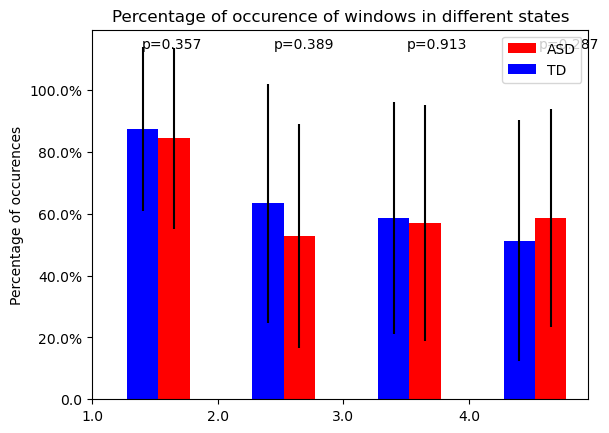

Successfully plotted !!!!


In [21]:
file_path = './Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/CPAC_NFNG__dfnc_post_process.mat'
save_path = None # './Final/Outputs_cpac_NFNG/POC_cpac_NFNG_K4.jpg'
asd_idx = np.array(range(170), dtype = 'uint32')
td_idx = np.array(range(170,365), dtype = 'uint32')
groups = {'ASD' : asd_idx, 'TD' : td_idx}
n_states = 4
n_windows_per_sub = 130

poc_dict, p_dict = utils.get_poc(file_path, groups, n_states, n_windows_per_sub)
print('p-values of 4 states : ', p_dict)
utils.plot_poc(poc_dict, p_dict, save_path)

## Analysis of State vector stats

In [22]:
cs = scipy.io.loadmat('./Final/Outputs_cpac_NFNG/DFNC_cpac_NFNG/Stats_K4/CPAC_NFNG__dfnc_cluster_stats.mat')
print('Cluster stats using GIFT mat file keys : ', cs.keys())

Cluster stats using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'thresholdWindows', 'dfnc_corrs', 'state_vector_stats', 'nuisance_cov_file'])


In [23]:
frac_time_states = cs['state_vector_stats'][0][0][0]
print("Shape of fraction time states : ", frac_time_states.shape)

Shape of fraction time states :  (365, 4)


['ASD', 'TD']
Groups :  ['ASD', 'TD']


/home/krishna/Downloads/MS_Thesis/VinceD/utils.py:164: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_ytick_labels)


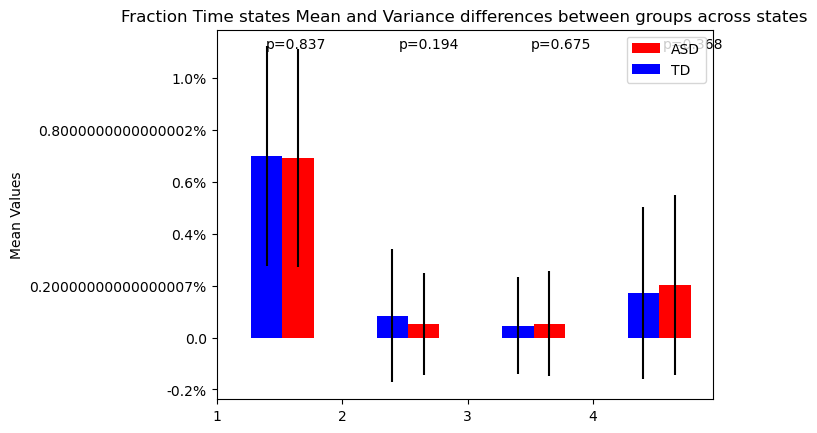

In [24]:
n_states = 4
pvalues_dict = utils.get_pvalues(frac_time_states, groups, n_states)   # P-values dictionary
mean_groups, std_groups = utils.get_mean_std(frac_time_states, groups, n_states)
utils.plot_groups(mean_groups, std_groups, pvalues_dict, title = 'Fraction Time states')

In [25]:
mean_dwell_time = cs['state_vector_stats'][0][0][1]
print("Shape of fraction time states : ", mean_dwell_time.shape)

Shape of fraction time states :  (365, 4)


['ASD', 'TD']
Groups :  ['ASD', 'TD']


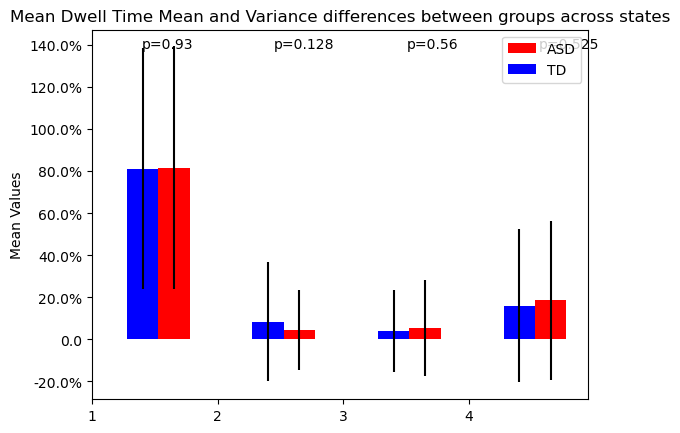

In [26]:
n_states = 4
pvalues_dict = utils.get_pvalues(mean_dwell_time, groups, n_states)   # P-values dictionary
mean_groups, std_groups = utils.get_mean_std(mean_dwell_time, groups, n_states)
utils.plot_groups(mean_groups, std_groups, pvalues_dict, title = 'Mean Dwell Time')

Shape of fraction time states :  (365, 4, 4)


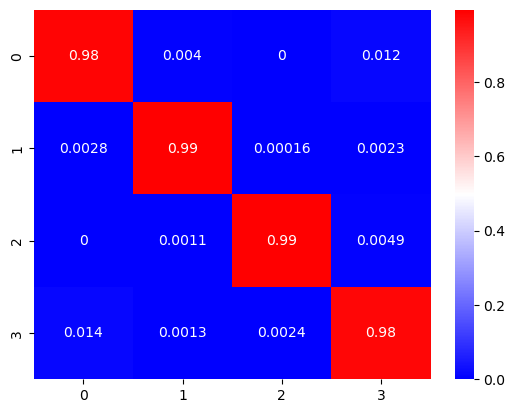

In [27]:
transition_matrix = cs['state_vector_stats'][0][0][2]
print("Shape of fraction time states : ", transition_matrix.shape)
transition_matrix_mean = np.mean(transition_matrix, axis = 0)
sns.heatmap(transition_matrix_mean, annot=True, cmap = 'bwr')
plt.show()
plt.close()

Mean of ASD Transition matrix shape :  (4, 4)
Mean of TD Transition matrix shape :  (4, 4)


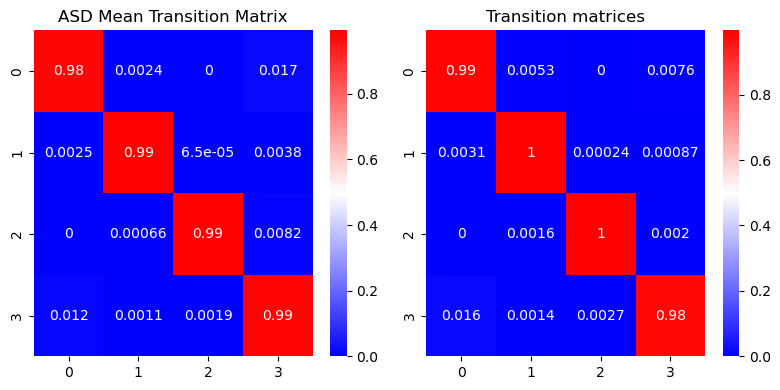

In [28]:
asd_tm = transition_matrix[asd_idx]     # ASD python indices
td_tm = transition_matrix[td_idx]       # TD python indices
asd_tm_mean = np.mean(asd_tm, axis = 0)
td_tm_mean = np.mean(td_tm, axis = 0)
print('Mean of ASD Transition matrix shape : ', asd_tm_mean.shape)
print('Mean of TD Transition matrix shape : ', td_tm_mean.shape)

fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(8,4))

ax1 = sns.heatmap(asd_tm_mean, annot=True, cmap = 'bwr', ax = ax1)
ax1.set_title('ASD Mean Transition Matrix')
ax2 = sns.heatmap(td_tm_mean, annot=True, cmap = 'bwr', ax = ax2)
ax2.set_title('TD Mean Transition Matrix')
plt.title('Transition matrices')
plt.tight_layout()
plt.show()
plt.close()

In [13]:
num_transitions = cs['state_vector_stats'][0][0][3]
print("Shape of fraction time states : ", num_transitions.shape)
asd_nt = num_transitions[asd_idx, :]
td_nt = num_transitions[td_idx, :]
_, pvalue_nt = scipy.stats.ttest_ind(asd_nt, td_nt)
print('P-value of Number of transitions : ', pvalue_nt)

Shape of fraction time states :  (365, 1)
P-value of Number of transitions :  [0.7855859]
